# **Project: MapGAN**
## Authors: Neill Shikada and Melanie Sharif
## Professor: Robin Burke
## Course: INFO5604

If you want to run this code locally using Anaconda, follow the instructions [here](https://research.google.com/colaboratory/local-runtimes.html):
1. Open Anaconda command prompt

2. Ensure that Jupyter has the proper extensions enabled
  `jupyter-serverextension enable jupyter_http_over_ws`

3. Run Jupyter Notebook and allow access to Google Colab with this code
  `jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com'`
  
4. Click the dropdown in the top left of Google Colab Notebook, select `Connect to a local runtime`

5. Copy the `http://localhost:8888/?token=###`  link from the Anaconda command prompt

6. Paste into the Google Colab url space

7. It should connect! Then keep the Jupyter Notebook open the whole time you code as this is where your code is running locally

# Import Dependencies

1. Install any package that needs to be installed

In [ ]:
!pip install earthengine-api --upgrade

  Using cached earthengine-api-0.1.334.tar.gz (244 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 829.2/829.2 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached google_cloud_storage-2.6.0-py2.py3-none-any.whl (105 kB)
  Using cached google_api_python_client-2.68.0-py2.py3-none-any.whl (10.6 MB)
  Using cached google_auth_httplib2-0.1.0-py2.py3-none-any.whl (9.3 kB)
  Using cached httplib2-0.21.0-py3-none-any.whl (96 kB)
  Using cached google_api_core-2.11.0-py3-none-any.whl (120 kB)
  Using cached uritemplate-4.1.1-py2.py3-none-any.whl (10 kB)
  Using cached google_resumable_media-2.4.0-py2.py3-none-any.whl (77 kB)
  Using cached google_cloud_core-2.3.2-py2.py3-none-any.whl (29 kB)
  Using cached googleapis_common_protos-1.57.0-py2.py3-none-any.whl (217 kB)
  Using cached google_crc32c-1.5.0-cp39

In [7]:
!pip install geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 7.2 MB/s 
     |████████████████████████████████| 3.5 MB 46.9 MB/s 
     |████████████████████████████████| 98 kB 4.4 MB/s 
     |████████████████████████████████| 46 kB 2.3 MB/s 
     |████████████████████████████████| 130 kB 61.7 MB/s 
     |████████████████████████████████| 3.7 MB 52.6 MB/s 
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 1.3 MB 52.5 MB/s 
     |████████████████████████████████| 198 kB 65.8 MB/s 
     |████████████████████████████████| 99 kB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 68.2 MB/s 
     |████████████████████████████████| 128 kB 46.5 MB/s 
     |████████████████████████████████| 1.6 MB 57.1 MB/s 
     |████████████████████████████████| 79 kB 8.1 MB/s 
  Created wheel for ee-extra: filename=ee_extra-0.0.14-py3-none-any.whl size=209116 sha256=d9e55e7c7

In [ ]:
!pip install folium

  Using cached folium-0.13.0-py2.py3-none-any.whl (96 kB)
  Using cached branca-0.6.0-py3-none-any.whl (24 kB)


2. Import all the necessary packages

In [1]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [3]:
import os

In [4]:
import numpy as np

In [5]:
# Folium will be used for visualization purposes. It is a package that enables Google-Maps-like interactive maps
import folium
print(folium.__version__)

0.12.1.post1


In [8]:
import geemap

In [9]:
# Enable access to Google Earth Engine. If you are running this locally, you have to right click and open the link in a new tab (otherwise it'll come up with an error)
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=QR6W05YpVynTLesVRCToTyWBUORPDjwbF0EuIdrQoNM&tc=rxUXIP-FVvmcFjrym_L46FxS-kFloJpXgH1EhpIUIUA&cc=T5Txp3gJc5fmIzWSZx_WFeOh60qCSb64g7PoNhGxt2g

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfgeXvtdXKsSZ5rdKF66PudBszC17Vo4tVDdjrsnHQgpYY9o3SmlZhGU9SE

Successfully saved authorization token.


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Define Variables

## Specify Cloud Storage Bucket
Google Colab uses Google Storage Buckets to run any code, so you have to have one and specify it!

In [ ]:
OUTPUT_BUCKET = 'mapgan'

Define database variables. Here, we're using a database of [global settlement patterns](https://developers.google.com/earth-engine/datasets/catalog/DLR_WSF_WSF2015_v1) and [Landsat 9 imagery](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1?hl=en)

In [ ]:
STL = ee.Image("DLR/WSF/WSF2015/v1")
L9SR = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")
STL_BANDS = ['settlements']
RGB_BANDS = ['B4', 'B3', 'B2']

In [ ]:
TOKYO = [35.6762, 139.6503]
BOULDER = [40.0150, -105.2705]

Define the file paths for data

In [ ]:
TRAIN_FILE_PREFIX = 'Training_demo'
TEST_FILE_PREFIX = 'Testing_demo'
file_extension = '.tfrecord.gz'
TRAIN_FILE_PATH = 'gs://' + OUTPUT_BUCKET + '/' + TRAIN_FILE_PREFIX + file_extension
TEST_FILE_PATH = 'gs://' + OUTPUT_BUCKET + '/' + TEST_FILE_PREFIX + file_extension


In [ ]:
# Your Earth Engine username.  This is used to import a classified image
# into your Earth Engine assets folder.
USER_NAME = 'nesh5910@colorado.edu'

# Cloud Storage bucket into which training, testing and prediction 
# datasets will be written.  You must be able to write into this bucket.
OUTPUT_BUCKET = 'mapgan'

# Use Landsat 8 surface reflectance data for predictors.
L9SR = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")
SWISS = ee.ImageCollection("ORTHO/Switzerland/SWISSIMAGE/10cm")
# Use these bands for prediction.
# The bands are different for each dataset in Earth Engine, but we are looking for the raw RGB values of the images
SWISS_BANDS = ['R', 'G', 'B']
BANDS = ['B4', 'B3', 'B2']

BOULDER = [40.0150, -105.2705]
BERN = [46.9480, 7.4474]

# This is a trianing/testing dataset of points with known land cover labels.
LABEL_DATA = ee.FeatureCollection('projects/google/demo_landcover_labels')
# The labels, consecutive integer indices starting from zero, are stored in
# this property, set on each point.
LABEL = 'landcover'
# Number of label values, i.e. number of classes in the classification.
N_CLASSES = 3

# These names are used to specify properties in the export of
# training/testing data and to define the mapping between names and data
# when reading into TensorFlow datasets.
FEATURE_NAMES = list(BANDS)
FEATURE_NAMES.append(LABEL)

# File names for the training and testing datasets.  These TFRecord files
# will be exported from Earth Engine into the Cloud Storage bucket.
TRAIN_FILE_PREFIX = 'Training_demo'
TEST_FILE_PREFIX = 'Testing_demo'
file_extension = '.tfrecord.gz'
TRAIN_FILE_PATH = 'gs://' + OUTPUT_BUCKET + '/' + TRAIN_FILE_PREFIX + file_extension
TEST_FILE_PATH = 'gs://' + OUTPUT_BUCKET + '/' + TEST_FILE_PREFIX + file_extension

# File name for the prediction (image) dataset.  The trained model will read
# this dataset and make predictions in each pixel.
IMAGE_FILE_PREFIX = 'Image_pixel_demo_'

# The output path for the classified image (i.e. predictions) TFRecord file.
OUTPUT_IMAGE_FILE = 'gs://' + OUTPUT_BUCKET + '/Classified_pixel_demo.TFRecord'
# Export imagery in this region.
EXPORT_REGION = ee.Geometry.Rectangle([-122.7, 37.3, -121.8, 38.00])
# The name of the Earth Engine asset to be created by importing
# the classified image from the TFRecord file in Cloud Storage.
OUTPUT_ASSET_ID = 'users/' + USER_NAME + '/Classified_pixel_demo'

In [ ]:
# This function is from the sample Google Colab CNN code to import earth engine data into folium
# https://colab.research.google.com/github/giswqs/qgis-earthengine-examples/blob/master/Folium/ee-api-folium-setup.ipynb#scrollTo=7uSjLbh1LBeX

# Define a method for displaying Earth Engine image tiles on a folium map.
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [50]:
opticalBands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Use Landsat 8 surface reflectance data.
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

# Cloud masking function.
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  mask2 = image.mask().reduce('min')
  mask3 = image.select(opticalBands).gt(0).And(
          image.select(opticalBands).lt(10000)).reduce('min')
  mask = mask1.And(mask2).And(mask3)
  return image.select(opticalBands).divide(10000)

# The image input data is a cloud-masked median composite.
image = l8sr.filterDate('2015-01-01', '2017-12-31').map(maskL8sr).median()

# Use folium to visualize the imagery.
mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=TOKYO, zoom_start=5)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

NameError: ignored

In [ ]:
l8sr_f = l8sr.filter(ee.Filter.bounds(listOfFeaturesFc))
l8sr_f

In [53]:
# A list of the megacities of the world and their geographic coordinates
# Taken from https://en.wikipedia.org/wiki/Megacity
# https://mbonnema.github.io/GoogleEarthEngine/05-time-series/
# https://developers.google.com/earth-engine/apidocs/ee-featurecollection
# https://developers.google.com/earth-engine/apidocs/ee-geometry-point-coordinates

listOfFeatures = [
  ee.Feature(ee.Geometry.Point(77.3530, 12.5844), {'city': 'Bangalore'}),
  ee.Feature(ee.Geometry.Point(100.2939, 13.4509), {'city': 'Bangkok'}),
  ee.Feature(ee.Geometry.Point(116.2351, 39.5424 ), {'city': 'Beijing'}),
  ee.Feature(ee.Geometry.Point(-74.420, 4.4240), {'city': 'Bogota'}),
  ee.Feature(ee.Geometry.Point(-58.2254, -34.3612), {'city': 'Buenos Aires'}),
  ee.Feature(ee.Geometry.Point(31.14, 30.02), {'city': 'Cairo'}),
  ee.Feature(ee.Geometry.Point(104.0348, 30.3936), {'city': 'Chengdu'}),
  ee.Feature(ee.Geometry.Point(80.16145, 13.04577), {'city': 'Chennai'}),
  ee.Feature(ee.Geometry.Point(106.3301, 29.3349), {'city': 'Chongqing'}),
  ee.Feature(ee.Geometry.Point(77.1348, 28.3636), {'city': 'Delhi'}),
  ee.Feature(ee.Geometry.Point(90.2320, 23.4550), {'city': 'Dhaka'}),
  ee.Feature(ee.Geometry.Point(113.1536, 23.0748), {'city': 'Guangzhou'}),
  ee.Feature(ee.Geometry.Point(120.0911, 30.1601), {'city': 'Huangzhou'}),
  ee.Feature(ee.Geometry.Point(106.4207, 10.4632), {'city': 'Ho Chi Minh City'}),
  ee.Feature(ee.Geometry.Point(78.29121, 17.23060), {'city': 'Hyderabad'}),
  ee.Feature(ee.Geometry.Point(28.5718, 41.0049), {'city': 'Istanbul'}),
  ee.Feature(ee.Geometry.Point(106.4939, -6.1030), {'city': 'Jakarta'}),
  ee.Feature(ee.Geometry.Point(28.244, -26.1216), {'city': 'Johannesburg'}),
  ee.Feature(ee.Geometry.Point(67.036, 24.5136), {'city': 'Karachi'}),
  ee.Feature(ee.Geometry.Point(15.1920, -4.1930), {'city': 'Kinshasa'}),
  ee.Feature(ee.Geometry.Point(88.2212, 22.3403), {'city': 'Kolkata'}),
  ee.Feature(ee.Geometry.Point(3.384082, 6.455027), {'city': 'Lagos'}),
  ee.Feature(ee.Geometry.Point(74.2037, 31.3259), {'city': 'Lahore'}),
  ee.Feature(ee.Geometry.Point(-77.0215, -12.0336), {'city': 'Lima'}),
  ee.Feature(ee.Geometry.Point(-0.739, 51.3026), {'city': 'London'}),
  ee.Feature(ee.Geometry.Point(-118.15, 34.03), {'city': 'Los Angeles'}),
  ee.Feature(ee.Geometry.Point(121, 14.58), {'city': 'Metro Manila'}),
  ee.Feature(ee.Geometry.Point(-99.8, 19.26), {'city': 'Mexico City'}),
  ee.Feature(ee.Geometry.Point(37.372, 55.4521), {'city': 'Moscow'}),
  ee.Feature(ee.Geometry.Point(72.5239, 19.0434), {'city': 'Mumbai'}),
  ee.Feature(ee.Geometry.Point(136.54, 35.11), {'city': 'Nagoya'}),
  ee.Feature(ee.Geometry.Point(-74.0022, 40.4246), {'city': 'New York City'}),
  ee.Feature(ee.Geometry.Point(135.308, 34.4138), {'city': 'Osaka'}),
  ee.Feature(ee.Geometry.Point(2.2108, 48.5124), {'city': 'Paris'}),
  ee.Feature(ee.Geometry.Point(-43.1221, -22.5441), {'city': 'Rio de Janeiro'}),
  ee.Feature(ee.Geometry.Point(-46.38, -23.33), {'city': 'São Paulo'}),
  ee.Feature(ee.Geometry.Point(126.5924, 37.3336), {'city': 'Seoul'}),
  ee.Feature(ee.Geometry.Point(121.2829, 31.1343), {'city': 'Shanghai'}),
  ee.Feature(ee.Geometry.Point(114.0335, 22.3229), {'city': 'Shenzhen'}),
  ee.Feature(ee.Geometry.Point(51.2320, 35.4121), {'city': 'Tehran'}),
  ee.Feature(ee.Geometry.Point(117.1219, 39.0801), {'city': 'Tianjin'}),
  ee.Feature(ee.Geometry.Point(139.4132, 35.4123), {'city': 'Tokyo'}),
  ee.Feature(ee.Geometry.Point(114.1817, 30.3536), {'city': 'Wuhan'}),
  ee.Feature(ee.Geometry.Point(118.0520, 24.2847), {'city': 'Xiamen'}),
  ee.Feature(ee.Geometry.Point(108.5714, 34.1554), {'city': 'Xi\'an'})
]

listOfFeaturesFc = ee.FeatureCollection(listOfFeatures)

In [54]:
opticalBands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Use Landsat 8 surface reflectance data.
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

Map = geemap.Map(zoom = 10)

# Cloud masking function.
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  mask2 = image.mask().reduce('min')
  mask3 = image.select(opticalBands).gt(0).And(
          image.select(opticalBands).lt(10000)).reduce('min')
  mask = mask1.And(mask2).And(mask3)
  return image.select(opticalBands).divide(10000)

# The image input data is a cloud-masked median composite.
# image = l8sr.filterDate('2015-01-01', '2017-12-31').filterBounds(ee.Geometry.Point(TOKYO[1], TOKYO[0]))
image = l8sr.filterDate('2015-01-01', '2017-12-31').filterBounds(listOfFeaturesFc).map(maskL8sr).median()

# sets image variables
rgbVis = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.3
};

Map.setCenter(139.6503, 35.6762)
# adds image layers to map
Map.addLayer(image, rgbVis, 'Cities')

Map

Map(center=[35.6762, 139.6503], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

In [65]:
ee.Algorithms.Describe(image.first())

In [80]:
# Defined the dataset and filter the Landsat 8 data by date, cloud coverage, and megacity coordinates
citiesDataset = l8sr.filterDate('2015-01-01', '2017-12-31').filterBounds(listOfFeaturesFc).map(maskL8sr)
citiesDataset.size()

# Setup the Neural Network

In [58]:
import scipy as sp    # import scipy for 
import pandas as pd   # import pandas for data formatting
import numpy as np    # import numpy for data formatting

In [59]:
import matplotlib.pyplot as plt
import seaborn as sb

In [60]:
import tensorflow as tf

In [66]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD

In [62]:
from PIL import Image
from tqdm import tqdm
import os 
import time

In [77]:
from google.colab import drive
drive.mount('/content/drive')

FOLDER = 'fcnn-demo'
TRAINING_BASE = 'training_patches'

GENERATE_RES = 2 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

RESPONSE = 'impervious'

# Preview image
PREVIEW_ROWS = 2
PREVIEW_COLS = 2
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATASET = l8sr.filterDate('2015-01-01', '2017-12-31').filterBounds(listOfFeaturesFc).map(maskL8sr)
BUCKET = "/content/drive/MyDrive/mapGAN/data"
EPOCHS = 100
BATCH_SIZE = 16
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Will generate 64px square images.


In [78]:
type(DATASET)

ee.imagecollection.ImageCollection

In [84]:
# Convert the feature collections to lists for iteration.
TRAINING_DATA = citiesDataset.toList(citiesDataset.size())

training_binary_path = os.path.join(BUCKET,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

start = time.time()
print("Loading training images...")

training_data = []

# TODO This for loop keeps giving the error "user memory exceeded" even with Google Compute Units
for filename in range(TRAINING_DATA.size().getInfo()):
    path = os.path.join(BUCKET,filename)
    image = Image.open(path).resize((GENERATE_SQUARE,
          GENERATE_SQUARE),Image.ANTIALIAS)
    training_data.append(np.asarray(image))
training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
          GENERATE_SQUARE,IMAGE_CHANNELS))
training_data = training_data.astype(np.float32)
training_data = training_data / 127.5 - 1.


print("Saving training image binary...")
np.save(training_binary_path,training_data)
elapsed = time.time()-start

Loading training images...


EEException: ignored

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(BUCKET,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [ ]:
#building the generator
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

In [ ]:
# 
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

tf.Tensor([[0.5007379]], shape=(1, 1), dtype=float32)


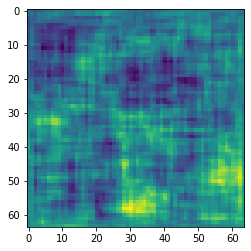

In [ ]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print(decision)

cross_entropy = tf.keras.losses.BinaryCrossentropy()

#discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
#generator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
#discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [ ]:
#from https://www.tensorflow.org/tutorials/generative/dcgan
#using pre-compiling
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

#training 
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

train(train_dataset, EPOCHS)

Epoch 1, gen loss=0.9690646529197693,disc loss=1.5506353378295898, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 125ms/step
Epoch 2, gen loss=1.2313545942306519,disc loss=1.3242579698562622, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 3, gen loss=0.9897303581237793,disc loss=1.3891716003417969, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 4, gen loss=1.120313286781311,disc loss=1.1489533185958862, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 5, gen loss=1.3530868291854858,disc loss=1.042638897895813, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 6, gen loss=1.598588466644287,disc loss=0.9105803370475769, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 7, gen loss=1.4682759046554565,disc loss=0.8695600032806396, {hms_string(epoch_elapsed)}
1/1 [====================

In [ ]:
# Save the model
generator.save('generator.h5')
discriminator.save('discriminator.h5')